In [41]:
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2
%matplotlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.rcParams['image.cmap'] = 'gist_earth'

from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util

nx = 512
ny = 512

generator = image_gen.get_image_gen(nx, ny, cnt=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: Qt5Agg


In [25]:
x_test, y_test = generator(1)

/home/jericho/ML_medphys/tf_unet/tf_unet/image_gen.py:100: RuntimeWarning: invalid value encountered in log
  np.random.normal(0, np.sqrt(np.exp(nr[:, j]) * 2500)) / 2500))
/home/jericho/ML_medphys/tf_unet/tf_unet/image_gen.py:125: RuntimeWarning: invalid value encountered in log
  0, np.sqrt(np.exp(nr2[:, i]) * 2500), size=image.shape)[m] / 2500))


In [26]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
print(type(x_test[0,0,0,0]))
print(type(y_test[0,0,0,0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [27]:
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32)

Layers 3, features 32, filter size 3x3, pool size: 2x2


In [28]:
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [40]:
path = trainer.train(generator, "./unet_trained", training_iters=20, epochs=40, display_step=2)

UnboundLocalError: local variable 'optimizer' referenced before assignment

In [32]:
prediction = net.predict("./unet_trained/model.cpkt", x_test)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.cpkt
Model restored from file: ./unet_trained/model.cpkt


IndexError: index 1 is out of bounds for axis 0 with size 1

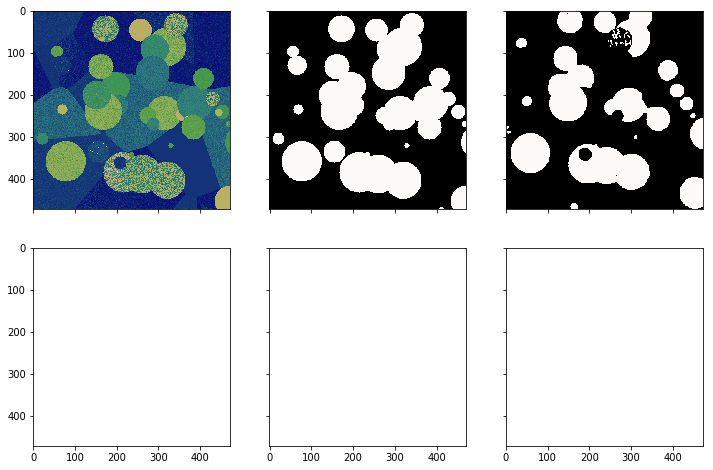

In [39]:
%matplotlib inline
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
for i in range(ax.shape[0]):
    ax[i, 0].imshow(x_test[i,...,0], aspect="auto")
    ax[i, 1].imshow(y_test[i,...,1], aspect="auto")
    mask = prediction[i,...,1] > 0.9
    ax[i, 2].imshow(mask, aspect="auto")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Ground truth")
ax[0, 2].set_title("Prediction")
fig.tight_layout()
fig.savefig("docs/toy_problem.png")

In [9]:
from keras.utils import plot_model
plot_model(net, to_file='model.png')

AttributeError: 'Unet' object has no attribute 'layers'

In [8]:
net.layers

AttributeError: 'Unet' object has no attribute 'layers'

In [10]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Download, extract and load MNIST dataset
data = input_data.read_data_sets('MNIST_data', one_hot=True)

# Define Placeholders for data and labels
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32,[None,784],name="x")
    y_true = tf.placeholder(tf.float32,[None,10],name="labels")

# Define model variables
with tf.name_scope('Weights'):
    weights = tf.Variable(tf.random_uniform([784,10],-1,1),name="weights")
with tf.name_scope('Biases'):
    biases = tf.Variable(tf.zeros([10]),name="biases")

# Define the model
with tf.name_scope('LinearModel'):
    logits = tf.matmul(x,weights) + biases
    y_pred = tf.nn.softmax(logits)

# Define cost measure
with tf.name_scope('CrossEntropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)
    loss = tf.reduce_mean(cross_entropy)

# create optimizer
with tf.name_scope('GDOptimizer'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(loss)

with tf.name_scope('Accuracy'):
    y_pred_cls = tf.argmax(y_pred,dimension=1)
    y_true_cls = tf.argmax(y_true,dimension=1)
    correct_pred = tf.equal(y_pred_cls,y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

# adding summary
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
tf.summary.histogram("weights", weights)
tf.summary.histogram("biases", biases)
summary_op = tf.summary.merge_all()


with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs', graph=tf.get_default_graph())
    num_iter = 1000
    sess.run(tf.global_variables_initializer())

    for i in range(num_iter):
        x_batch,y_batch = data.train.next_batch(100)
        feed_dict = {x: x_batch,y_true: y_batch}
        _,summary = sess.run([train_step,summary_op],feed_dict)
        writer.add_summary(summary,i)
        if i % 50 == 0:
            loss_val = sess.run(loss,feed_dict)
            print("Loss: ",loss_val)
    
    x_test,y_test = data.test.next_batch(10000)    
    print("Accuracy of model: ",accuracy.eval(feed_dict = {x:x_test,y_true:y_test}))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_2', defined at:
  File "/home/jericho/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jericho/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/jericho/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/jericho/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/jericho/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 263, in enter_eventloop
    self.eventloop(self)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/eventloops.py", line 134, in loop_qt5
    return loop_qt4(kernel)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/eventloops.py", line 122, in loop_qt4
    _loop_qt(kernel.app)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/eventloops.py", line 106, in _loop_qt
    app.exec_()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/eventloops.py", line 39, in process_stream_events
    kernel.do_one_iteration()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 298, in do_one_iteration
    stream.flush(zmq.POLLIN, 1)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 357, in flush
    self._handle_recv()
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-41bb611c4191>", line 1, in <module>
    net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=16)
  File "/home/jericho/ML_medphys/tf_unet/tf_unet/unet.py", line 188, in __init__
    self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/jericho/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
